# Testing the rarity of the standard genetic code

- 100,000 alternative genetic codes were generated by following the method proposed by Haig & Hurst (1991), where the amino acid assignments to codon blocks were randomly permuted.

- We defined the ARF disorder statistic that indicates the propensity for intrinsic disorder of each ARF. This statistic was estimated from the amino acid composition of each ARF based on a given genetic code, amino acid pair frequencies of canonical ORFs, and GC%.

- Example 
  - Let us calculate the stats for +2 ARF, assuming the standard genetic code and the GC% = 64.1%
  - First, we obtained the expected frequencies of all amino acids in +2 ARFs.
    - Consider the case of Gln-Pro as an example. Assume that the Gln-Pro frequency = 0.5%.
    - We estimated the relative codon pair freq. for Gln-Pro:
      $$
      \begin{align*}
      & && \mathrm{CAACCA}:\mathrm{CAACCC}:\mathrm{CAACCG}:\mathrm{CAACCT}:\mathrm{CAGCCA}:\mathrm{CAGCCC}:\mathrm{CAGCCG}:\mathrm{CAGCCT}\\
      &=&& (0.641^3\cdot0.359^3):(0.641^4\cdot0.359^2):(0.641^4\cdot0.359^2):(0.641^3\cdot0.359^3):(0.641^4\cdot0.359^2):(0.641^5\cdot0.359^1):(0.641^5\cdot0.359^1):(0.641^4\cdot0.359^2)\\
      &=&& 6.44405\%:11.50595\%:11.50595\%:6.44405\%:11.50595\%:20.54405\%:20.54405\%:11.50595\%
      \end{align*}
      $$
    - For example, the +2 ARF codon of CAACCT is ACC, which is translated into Thr according to the standard genetic code. Therefore, 0.5% × 6.44405% = 0.03222025% was added to the frequency of Thr in +2 ARF.
    - We repeated this procedure for all amino acid pairs and all codon pairs to obtain the expected frequencies of all amino acids in +2 ARF
  - Then, we computed the sum of the amino acid frequencies of ARFs, weighted by the TOP-IDP scale (Campen et al., 2008), as a measure of propensity for intrinsic disorder.
 

In [1]:
import numpy as np
import pandas as pd
from Bio.Seq import reverse_complement
from collections import Counter
from functools import partial
from itertools import product, chain
from tqdm.notebook import tqdm
from pyscripts.config import path2
from pyscripts.datasets import Metadata
from pyscripts.genomeutil import sliding
metadata = Metadata()

In [2]:
standard = {
    'TTT': 'F', 'TCT': 'S', 'TAT': 'Y', 'TGT': 'C',
    'TTC': 'F', 'TCC': 'S', 'TAC': 'Y', 'TGC': 'C',
    'TTA': 'L', 'TCA': 'S', 'TAA': '*', 'TGA': '*',
    'TTG': 'L', 'TCG': 'S', 'TAG': '*', 'TGG': 'W',
    'CTT': 'L', 'CCT': 'P', 'CAT': 'H', 'CGT': 'R',
    'CTC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R',
    'CTA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R',
    'CTG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R',
    'ATT': 'I', 'ACT': 'T', 'AAT': 'N', 'AGT': 'S',
    'ATC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S',
    'ATA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R',
    'ATG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R',
    'GTT': 'V', 'GCT': 'A', 'GAT': 'D', 'GGT': 'G',
    'GTC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G',
    'GTA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G',
    'GTG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G',    
}

In [3]:
def custom_translate(seq, tbl):
    return ''.join([tbl[c] for c in sliding(seq, 3, 3)])

std_translate = partial(custom_translate, tbl=standard)

In [4]:
bicodons_summary = pd.read_pickle(path2.data/'kmer'/'bicodons_summary.pkl.bz2')
codons_summary = pd.read_pickle(path2.data/'kmer'/'codons_summary.pkl.bz2')
nts_summary = pd.read_pickle(path2.data/'kmer'/'nts_summary.pkl.bz2')

In [5]:
GCsummary = nts_summary.T.eval('(C+G) / (A+C+G+T)')
AAsummary = codons_summary.groupby(std_translate).sum()
biAAsummary = bicodons_summary.groupby(std_translate).sum()

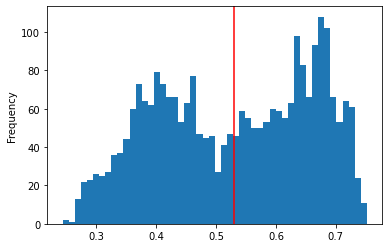

In [6]:
GCsummary.plot.hist(bins=50).axvline(GCsummary.mean(), c='r')

In [7]:
meanGC = GCsummary.mean()
AA_meanGC = AAsummary.T.mean()
biAA_meanGC = biAAsummary.T.mean()

highGC = GCsummary[GCsummary >= meanGC].mean()
AA_highGC = AAsummary.T.loc[GCsummary >= meanGC].mean()
biAA_highGC = biAAsummary.T.loc[GCsummary >= meanGC].mean()


lowGC = GCsummary[GCsummary < meanGC].mean()
AA_lowGC = AAsummary.T.loc[GCsummary < meanGC].mean()
biAA_lowGC  = biAAsummary.T.loc[GCsummary < meanGC].mean()

highGC, meanGC, lowGC

(0.6405974922021773, 0.5305268588257096, 0.4097219190767952)

In [8]:
def HH91(N, fix_stop=True, seed=None): 
    np.random.seed(seed)
    AAs = [*'ACDEFGHIKLMNPQRSTVWY'] if fix_stop else [*'ACDEFGHIKLMNPQRSTVWY*']
    for _ in range(N):
        AAmap = {'*': '*'}
        AAmap.update(dict(zip(AAs, np.random.permutation(AAs))))
        random_code = {k: AAmap[v] for k, v in standard.items()}
        yield random_code

In [9]:
codons = [*map(''.join, product('ACGT', repeat=3))]
bicodons = [*map(''.join, product('ACGT', repeat=6))]

In [10]:
topidp = pd.Series(dict(
    W = -0.884, F = -0.697, Y = -0.510, I = -0.486, 
    M = -0.397, L = -0.326, V = -0.121, N = +0.007, 
    C = +0.020, T = +0.059, A = +0.060, G = +0.166, 
    R = +0.180, D = +0.192, H = +0.302, Q = +0.318,
    S = +0.341, K = +0.586, E = +0.736, P = +0.987,
))

In [11]:
def get_idp_stats(rand_code, mode):
    weight_gc, freq_AA, freq_biAA = dict(
        highGC = (highGC, AA_highGC, biAA_highGC),
        meanGC = (meanGC, AA_meanGC, biAA_meanGC),
        lowGC  = (lowGC , AA_lowGC , biAA_lowGC )
    )[mode]
    rand_transl = lambda seq: custom_translate(seq, rand_code)
    
    gc_codon = pd.DataFrame(map(Counter, codons), index=codons).fillna(0)
    weight_codon = gc_codon.eval(f'{1-weight_gc}**(A+T) * {weight_gc}**(G+C)')
    codon_usage = weight_codon / weight_codon.groupby(rand_transl).transform('sum')
    
    gc_bicodon = pd.DataFrame(map(Counter, bicodons), index=bicodons).fillna(0)
    weight_bicodon = gc_bicodon.eval(f'{1-weight_gc}**(A+T) * {weight_gc}**(G+C)')
    bicodon_usage = weight_bicodon / weight_bicodon.groupby(rand_transl).transform('sum')
    
    est_codons = pd.Series({
        c: codon_usage.loc[c] * freq_AA.loc[rand_transl(c)]
        for c in codons
    })
    est_bicodons = pd.Series({
        bc: bicodon_usage.loc[bc] * freq_biAA.loc[rand_transl(bc)]
        for bc in bicodons
    })
    
    fw1 = lambda bc: rand_code[bc[1:4]]
    fw2 = lambda bc: rand_code[bc[2:5]]
    rc1 = lambda bc: rand_code[reverse_complement(bc[1:4])]
    rc2 = lambda bc: rand_code[reverse_complement(bc[2:5])]
    
    stats = pd.Series(dtype=float)
    for frame, arf in zip(['+1','+2','-1','-2'], [fw1, fw2, rc1, rc2]):
        est_arfAA = est_bicodons.groupby(arf).sum().drop('*')
        stats[frame] = topidp @ (est_arfAA / est_arfAA.sum())

    rc0 = lambda c: rand_code[reverse_complement(c)]
    est_arfAA = est_codons.groupby(rc0).sum().drop('*')
    stats['-0'] = topidp @ (est_arfAA / est_arfAA.sum())
    
    return stats

def get_idp_stats_highGC(rand_code): return get_idp_stats(rand_code, 'highGC')
def get_idp_stats_meanGC(rand_code): return get_idp_stats(rand_code, 'meanGC')
def get_idp_stats_lowGC(rand_code) : return get_idp_stats(rand_code, 'lowGC' )

from multiprocessing import Pool

with Pool(100) as pool:
    simulated_stats_highGC = pd.concat(
        tqdm(pool.imap_unordered(get_idp_stats_highGC, HH91(100000, fix_stop=True, seed=831)), total=100000), 
        axis=1
    )
    simulated_stats_meanGC = pd.concat(
        tqdm(pool.imap_unordered(get_idp_stats_meanGC, HH91(100000, fix_stop=True, seed=831)), total=100000), 
        axis=1
    )
    simulated_stats_lowGC  = pd.concat(
        tqdm(pool.imap_unordered(get_idp_stats_lowGC , HH91(100000, fix_stop=True, seed=831)), total=100000), 
        axis=1
    )
real_stats_highGC = get_idp_stats_highGC(standard)
real_stats_meanGC = get_idp_stats_meanGC(standard)
real_stats_lowGC  = get_idp_stats_lowGC(standard)


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

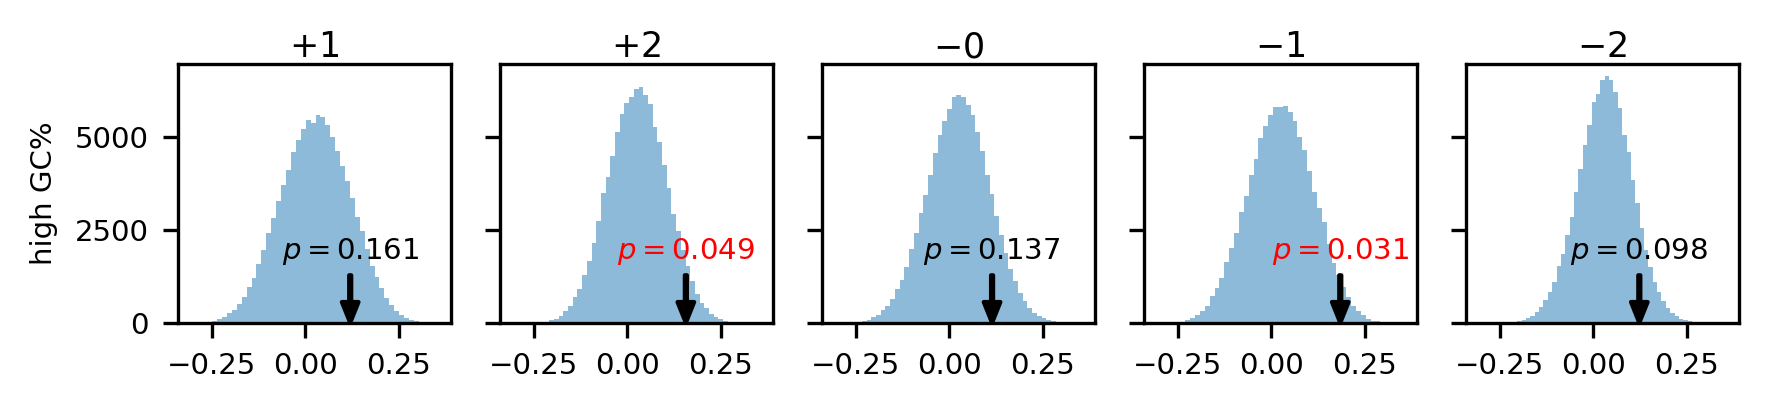

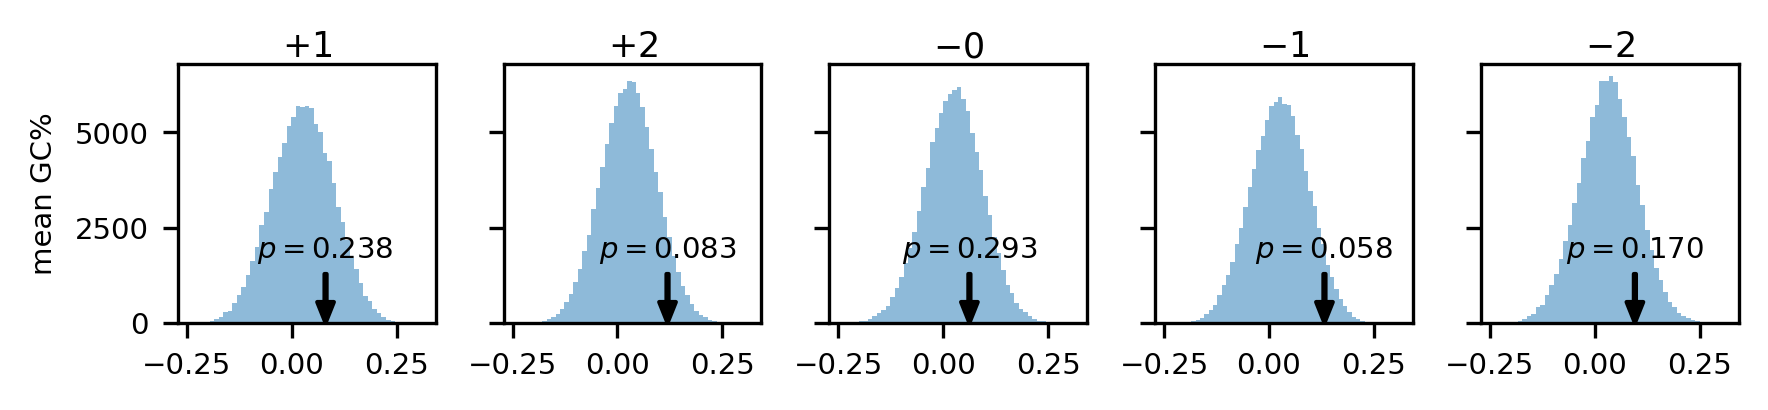

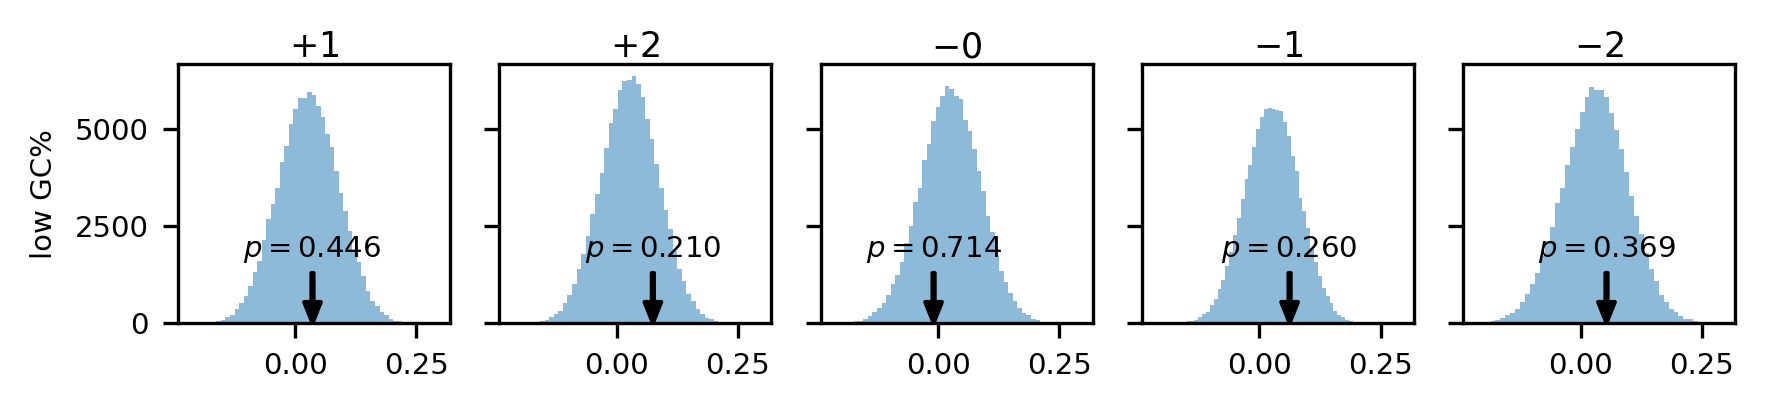

In [12]:
import matplotlib.pyplot as plt
mm = 1 / 25.4

with plt.rc_context({'font.size': 7}):
    annotate_kw = dict(arrowprops=dict(fc='k', shrink=0, width=0.5, headlength=5, headwidth=4), ha='center', va='bottom')
    
    for real_stats, simulated_stats, ylabel in zip(
        [real_stats_highGC, real_stats_meanGC, real_stats_lowGC], 
        [simulated_stats_highGC, simulated_stats_meanGC, simulated_stats_lowGC],
        ['high GC%', 'mean GC%', 'low GC%']
    ):
        
        fig, axes = plt.subplots(1, 5, figsize=(150*mm, 35*mm), sharex=True, sharey=True, dpi=300)

        for frame, ax in zip(['+1','+2','-0','-1','-2'], axes):
            simulated_stats.T[frame].plot.hist(bins=50, alpha=0.5, ax=ax)
            x = real_stats[frame]
            p = (simulated_stats.T[frame] > x).mean()
            ax.annotate(f'${p=:.03f}$', (x, 0),  (x, 1500), c='red' if p<0.05 else 'k', **annotate_kw)
            ax.set_title(f'${frame}$', pad=1)
        
        axes[0].set_ylabel(ylabel)
        fig.tight_layout()
    

Comfirmed reproducibility. Figures will be revised later.